## AWS y Intel Hackathon: Model Training

### Install Python SDKs

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.24

### Install PyTroch

In [3]:
!{sys.executable} -m pip install torch==1.1.0
!{sys.executable} -m pip install torchvision==0.3.0
!{sys.executable} -m pip install pillow==6.2.2
!{sys.executable} -m pip install --upgrade sagemaker
!{sys.executable} -m pip install torchsummary

     |████████████████████████████████| 676.9 MB 1.5 kB/s             
     |████████████████████████████████| 2.6 MB 24.4 MB/s            
     |████████████████████████████████| 2.1 MB 25.6 MB/s            
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 6.2.2 which is incompatible.
     |████████████████████████████████| 522 kB 25.6 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.87.0-py2.py3-none-any.whl size=721735 sha256=ecaf9fc7ef8628fa4b8efc8790c0456f734a48d0c7a4b9231eaec0c1f31f0758
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0a/d2/c0/292d072dd8cd79b2cbbb1e40502629e45ce86b44e4

### Setup

In [4]:
import time

import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats, display
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models

import torch

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session

from tqdm.notebook import tqdm

from torchsummary import summary
import glob
from PIL import Image

import random

set_matplotlib_formats("retina")

### Download the data

In [5]:
!mkdir data

### Original dataset
Run the two cells below to use the original dataset. It should provide good results in training and test although the training process will take several minutes.

In [ ]:
!wget https://www.dropbox.com/s/zhljom0hth586p9/dataset_original.zip

In [ ]:
!mv dataset_original.zip data/dataset.zip
!unzip -quo data/dataset.zip -d data/

dataset_path = "./data/dataset.zip"

### Reduced Dataset
Run the two cells below to use the reduced dataset. It should provide worse results than the original but it will reduce the training process time.

In [ ]:
!wget https://www.dropbox.com/s/evm0ts2obk7n3cb/dataset_reduced.zip

In [ ]:
!mv dataset_reduced.zip data/dataset.zip
!unzip -quo data/dataset.zip -d data/

dataset_path = "./data/dataset.zip"


### Dataset_for_tests
Run the two cells below to use a very reduced dataset. It can be used for very fast tests although it will yield to very poor results in the predictions and training accuracy. 

In [6]:
!wget https://www.dropbox.com/s/zivlm0skt19k3wh/dataset_for_tests.zip

--2022-04-20 18:10:22--  https://www.dropbox.com/s/zivlm0skt19k3wh/dataset_for_tests.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zivlm0skt19k3wh/dataset_for_tests.zip [following]
--2022-04-20 18:10:23--  https://www.dropbox.com/s/raw/zivlm0skt19k3wh/dataset_for_tests.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9c76263f8c96a9c78fd1d8726e.dl.dropboxusercontent.com/cd/0/inline/BjzZ7a3HOR-ozFw8lh-mB2Aoz1ThMmnAo60MwkZQbW3o1i_4Qh3obyIBUbUYbOHLbLcB5jJAxGC_szYvmYBmncxYcgSI418uGs9XtinhY_tF-1zXqoWwHbD9Gs6-4zyAa28j321QO_rvdplF1EMCd2csSxNcFCa9kpEK3FYbzfpt-w/file# [following]
--2022-04-20 18:10:23--  https://uc9c76263f8c96a9c78fd1d8726e.dl.dropboxusercontent.com/cd/0/inline/BjzZ7a3HOR-ozFw8lh-mB2Aoz1ThMmnAo60Mwk

In [7]:
!mv dataset_for_tests.zip data/dataset.zip
!unzip -quo data/dataset.zip -d data/

dataset_path = "./data/dataset.zip"

### Upload dataset to S3 as zip file

In [8]:
sm_sess = sagemaker.Session()
sess = sm_sess.boto_session
sm = sm_sess.sagemaker_client
role = get_execution_role()

In [9]:
account_id = sess.client("sts").get_caller_identity()["Account"]
bucket = "sagemaker-hackathon-demo-{}-{}".format(sess.region_name, account_id)
prefix = "hackathon"

try:
    if sess.region_name == "us-east-1":
        sess.client("s3").create_bucket(Bucket=bucket)
    else:
        sess.client("s3").create_bucket(
            Bucket=bucket, CreateBucketConfiguration={"LocationConstraint": sess.region_name}
        )
except Exception as e:
    print(e)

An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [10]:
bucket

'sagemaker-hackathon-demo-eu-west-1-017233837209'

In [11]:
s3_resource = boto3.resource("s3", region_name = sess.region_name)

inputs = None

try:

    
    inputs = sagemaker.Session().upload_data(path=dataset_path, bucket=bucket, key_prefix=prefix)
    print("input spec: {}".format(inputs))
except Exception as exp:
    print("exp: ", exp)


input spec: s3://sagemaker-hackathon-demo-eu-west-1-017233837209/hackathon/dataset.zip


### Training

In [12]:
!pygmentize model.py

import argparse
import json
import logging
import os
import sys

#import sagemaker_containers
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms

import boto3
import zipfile
from torch.utils.data import DataLoader

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

img_transform= {
    'dataset':
    transforms.Compose([
        transforms.Resize((28, 28)), 
        transforms.ToTensor(),
    ]),
    'training':
    transforms.Compose([
         transforms.RandomResizedCrop(size=224),
         transforms.RandomHorizontalFlip(),
    ]),
    'validation': 
    transforms.Compose([
        transforms.Resize(size=224),
    ]),
    'testing': 
    transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]),

In [13]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="model.py",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    instance_count=2,
    instance_type="ml.m4.xlarge",
    hyperparameters={"epochs": 6, "backend": "gloo"},
)

In [14]:
estimator.fit({"training": inputs})

2022-04-20 18:11:04 Starting - Starting the training job...ProfilerReport-1650478264: InProgress
...
2022-04-20 18:11:49 Starting - Preparing the instances for training......
2022-04-20 18:12:52 Downloading - Downloading input data...
2022-04-20 18:13:32 Training - Downloading the training image......
2022-04-20 18:14:30 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-20 18:14:31,328 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-20 18:14:31,332 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-20 18:14:31,347 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-20 18:14:31,351 sagemaker_pytorch_container.training INFO     Invoking user training script.
bash: cannot set terminal process group (-1): Inappropriate ioctl f

In [15]:
estimator.model_data

's3://sagemaker-eu-west-1-017233837209/pytorch-training-2022-04-20-18-11-03-880/output/model.tar.gz'

### Deployment

In [16]:
estimator.model_data

's3://sagemaker-eu-west-1-017233837209/pytorch-training-2022-04-20-18-11-03-880/output/model.tar.gz'

First we create a folder to save model trained model, and download the model.tar.gz file to local directory.

In [17]:
%%sh -s $estimator.model_data
mkdir model
aws s3 cp $1 model/ 
tar xvzf model/model.tar.gz --directory ./model

download: s3://sagemaker-eu-west-1-017233837209/pytorch-training-2022-04-20-18-11-03-880/output/model.tar.gz to model/model.tar.gz
model.pth
model.pth


Convert your model into the TorchScript format using torch.jit.trace or torch.jit.script.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model_loaded = torch.load("model/model.pth")
model = Net().to("cpu")
model = torch.nn.DataParallel(model)
model.load_state_dict(model_loaded)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [20]:
import subprocess

trace_input = torch.rand(1, 3, 28, 28)
traced_model = torch.jit.trace(model.eval(), trace_input)

torch.jit.save(traced_model, "model.pth")
subprocess.call(["tar", "-czvf", "traced_hackathon_model.tar.gz", "model.pth"])

0

In [21]:
!pygmentize deploy_ei.py

# Copyright 2019-2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.
from __future__ import absolute_import

import logging
import os
import sys

import torch

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

# To use new EIA inference API, customer should use attach_eia(model, eia_ordinal_number)
VERSIONS_USE_NEW_API = ["1.5.1"]


def predict_fn(input_data, model):
    logger.info(
        "Performing EIA inference with T

In [39]:
from sagemaker.pytorch import PyTorchModel
from datetime import datetime

instance_type = "ml.m4.xlarge"

# TorchScript model
tar_filename = "traced_hackathon_model.tar.gz"

# You can also upload model artifacts to S3
# print('Upload tarball to S3')
# model_data = sagemaker_session.upload_data(path=tar_filename, bucket=bucket, key_prefix=prefix)
model_data = tar_filename

endpoint_name = ("hackathon-ei-tracedd").replace(".", "").replace("_", "")

In [40]:
pytorch = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point="deploy_ei.py",
    framework_version="1.3.1",
    py_version="py3",
    sagemaker_session=sm_sess,
)

In [41]:
# Attach EI remotely

# Function will exit before endpoint is finished creating
predictor = pytorch.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=endpoint_name,
    wait=True,
)


-------!

In [42]:
predictor

img_resized (28, 28, 3)
x shape torch.Size([1, 3, 28, 28])


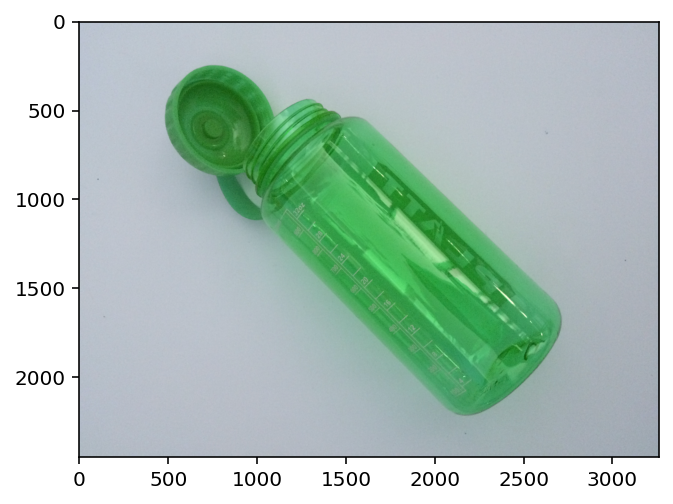

In [43]:
#Import Pytorch
import torch
import torchvision

import cv2 
import matplotlib.pyplot as plt


convert = torchvision.transforms.ToTensor()

file = "./plastic171.jpg"
# test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
test_image = cv2.imread(file)
plt.imshow(test_image, cmap='gray')

img_resized = cv2.resize(test_image, (28, 28), interpolation=cv2.INTER_LINEAR)
img_resized = cv2.bitwise_not(img_resized)
print("img_resized", img_resized.shape)

## Get our input image as a tensor. We add a dimension with "unsqueeze", because
## PyTorch is used to working with batches.
x = convert(img_resized).unsqueeze(0)

print("x shape", x.shape)




In [44]:
import numpy as np

# im_ = np.random.rand(1, 1, 28, 28)

# image = np.array(im_, dtype=np.float32)
response = predictor.predict(x)
print("response", response)
prediction = response.argmax(axis=1)[0]
print(prediction)

response [[-1.55122006 -1.73787999 -1.6699779  -1.58277488 -1.52114177]]
4


### Access the predictor from outside

In [32]:
endpoint = predictor.endpoint_name

'hackathon-ei-tracedd'

In [45]:
predictor.content_type

'application/x-npy'

In [47]:
from sagemaker.predictor import Predictor

endpoint = "hackathon-ei-tracedd"

payload = x
    
predictor2 = Predictor(endpoint)


In [48]:
predictor2

In [57]:
import tensorflow as tf
tensorByteProto = tf.io.serialize_tensor(x)
print("type", type(tensorByteProto))

AttributeError: module 'tensorflow' has no attribute 'io'

In [49]:
inference_response = predictor2.predict(x)
print (inference_response)

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: tensor([[[[0.2667, 0.2588, 0.2706,  ..., 0.2784, 0.2784, 0.2941],
          [0.2588, 0.2667, 0.2627,  ..., 0.2824, 0.2902, 0.2902],
          [0.2627, 0.2627, 0.2627,  ..., 0.2824, 0.2941, 0.2863],
          ...,
          [0.3020, 0.2784, 0.2784,  ..., 0.3490, 0.3490, 0.3686],
          [0.2980, 0.2902, 0.3020,  ..., 0.3529, 0.3608, 0.3686],
          [0.3059, 0.3020, 0.2941,  ..., 0.3686, 0.3647, 0.3804]],

         [[0.2353, 0.2275, 0.2353,  ..., 0.2549, 0.2588, 0.2627],
          [0.2235, 0.2314, 0.2275,  ..., 0.2667, 0.2667, 0.2745],
          [0.2314, 0.2235, 0.2235,  ..., 0.2588, 0.2706, 0.2627],
          ...,
          [0.2667, 0.2431, 0.2549,  ..., 0.3176, 0.3333, 0.3333],
          [0.2745, 0.2549, 0.2667,  ..., 0.3255, 0.3255, 0.3333],
          [0.2706, 0.2667, 0.2667,  ..., 0.3255, 0.3294, 0.3412]],

         [[0.1843, 0.1765, 0.1961,  ..., 0.2118, 0.2118, 0.2235],
          [0.1843, 0.1804, 0.1882,  ..., 0.2235, 0.2235, 0.2314],
          [0.1804, 0.1843, 0.1843,  ..., 0.2157, 0.2275, 0.2196],
          ...,
          [0.2275, 0.2039, 0.2118,  ..., 0.2902, 0.2902, 0.2941],
          [0.2314, 0.2078, 0.2275,  ..., 0.2902, 0.2902, 0.2980],
          [0.2353, 0.2275, 0.2314,  ..., 0.2863, 0.2941, 0.3020]]]]), type: <class 'torch.Tensor'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [59]:
import boto3

import json
 
endpoint = 'hackathon-ei-tracedd'
 
runtime = boto3.Session().client('sagemaker-runtime')
 
# Read image into memory
with open("plastic171.jpg", 'rb') as f:
    payload = f.read()
    


# Send image via InvokeEndpoint API
response = runtime.invoke_endpoint(EndpointName=endpoint, ContentType='application/x-image', Body=payload)

# Unpack response
result = json.loads(response['Body'].read().decode())

ReadTimeoutError: Read timeout on endpoint URL: "https://runtime.sagemaker.eu-west-1.amazonaws.com/endpoints/hackathon-ei-tracedd/invocations"

In [38]:
predictor.delete_endpoint()